<a href="https://colab.research.google.com/github/oopere/GANs/blob/main/C2_GAN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 - GAN Tutorial.
## Generate Cifar Images with a DCGAN.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

print (tf.__version__)

2.11.0


In [ ]:
def plot_results(images, n_cols=None, unnorm=True):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        imageorg = image
        if unnorm:
          imageorg = (image +1) * 0.5
        plt.imshow(imageorg)
        plt.axis("off")

In [ ]:
# download the training images
(X_train, _), _ = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


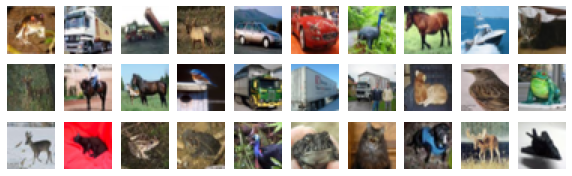

In [ ]:
plot_results(X_train[0:30], 10, False)

In [ ]:
# normalize pixel values
X_train = X_train.astype(np.float32)

#Rescale
#X_train = X_train.reshape(-1, 28, 28, 3) * 2. - 1.
X_train = (X_train -127.5) / 127.5

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

In [ ]:
X_train[1]

array([[[ 0.20784314,  0.3882353 ,  0.46666667],
        [-0.01176471,  0.07450981,  0.06666667],
        [-0.1764706 , -0.18431373, -0.25490198],
        ...,
        [-0.28627452, -0.25490198, -0.44313726],
        [-0.31764707, -0.29411766, -0.44313726],
        [-0.38039216, -0.3647059 , -0.4509804 ]],

       [[ 0.09803922,  0.25490198,  0.3254902 ],
        [ 0.13725491,  0.2       ,  0.20784314],
        [-0.01960784, -0.01960784, -0.07450981],
        ...,
        [-0.24705882, -0.22352941, -0.3882353 ],
        [-0.39607844, -0.37254903, -0.5137255 ],
        [-0.44313726, -0.42745098, -0.52156866]],

       [[ 0.09803922,  0.21568628,  0.28627452],
        [ 0.09019608,  0.14509805,  0.16862746],
        [-0.09803922, -0.09803922, -0.12156863],
        ...,
        [-0.38039216, -0.35686275, -0.49803922],
        [-0.46666667, -0.4509804 , -0.5686275 ],
        [-0.4745098 , -0.45882353, -0.5686275 ]],

       ...,

       [[ 0.37254903,  0.30980393,  0.3019608 ],
        [ 0

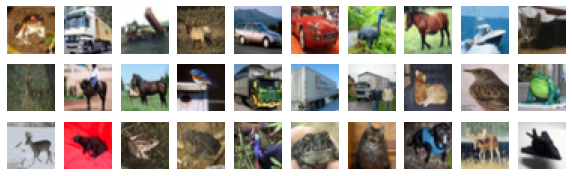

In [ ]:
plot_results(X_train[0:30], 10)

In [ ]:
noise_input = 100
generator = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 128, input_shape=[noise_input], 
                       activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Reshape([4, 4, 128]),
    keras.layers.BatchNormalization(),

    #First UpSample doubling the size to 8x8
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Second UpSample doubling the size to 16x16
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Last UpSample doubling the size to 32x32
    keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh'),
                                 ])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        262272    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                        

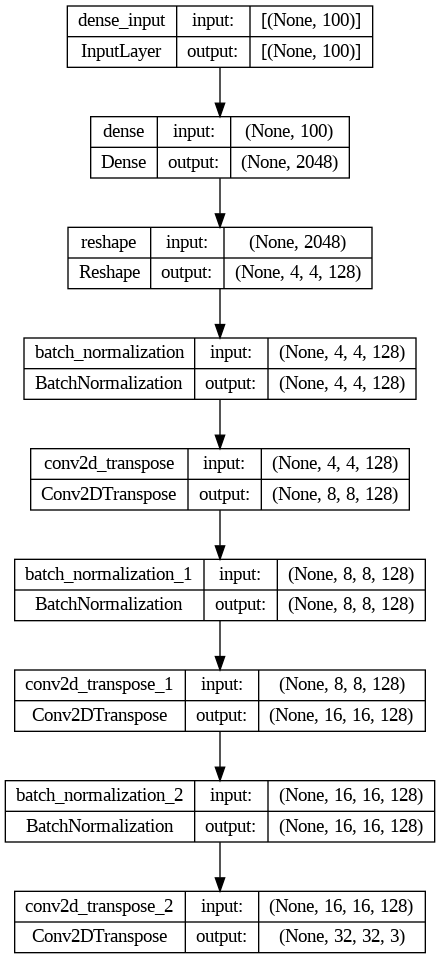

In [ ]:
plot_model(generator, show_shapes=True, 
           show_layer_names=True)

shape of the generated batch: (16, 32, 32, 3)


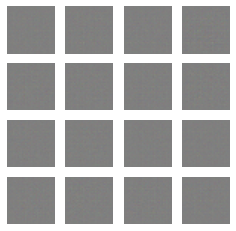

In [ ]:
# generate a batch of noise input (batch size = 16)
test_noise = tf.random.normal([16, noise_input])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

In [ ]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

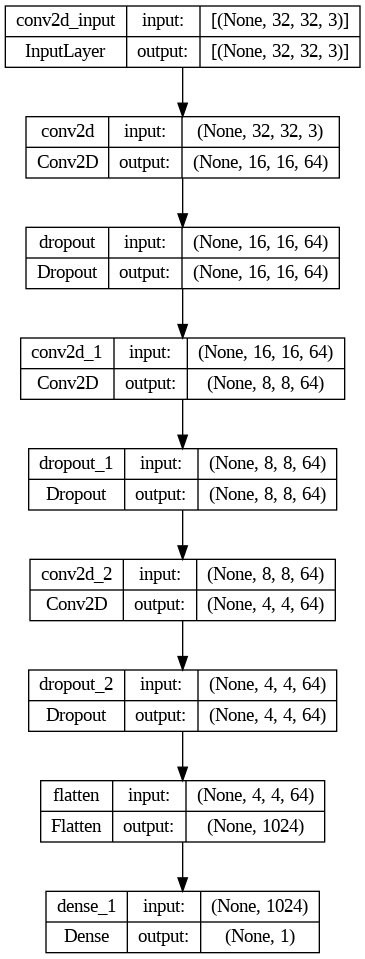

In [ ]:
plot_model(discriminator, show_shapes=True, 
           show_layer_names=True)

In [ ]:
gan = keras.models.Sequential([generator, discriminator])

In [ ]:
#discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gen = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizer_gen)

In [ ]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         739075    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 79745     
                                                                 
Total params: 818,820
Trainable params: 738,307
Non-trainable params: 80,513
_________________________________________________________________


In [ ]:
def smooth_positive(y):
  return y -0.2 + (np.random.random(y.shape) * 0.4)

def smooth_negative(y):
  return y + np.random.random(y.shape) * 0.3


In [ ]:
def generate_real_samples(dataset, n_samples):
  i = np.randint(0, dataset.shape[0], n_samples)
  X = dataset[i]
  y


In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=30):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
            discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
            discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))
            #discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_ones = smooth_positive(np.ones((batch_size, 1)))
            generator_labels = tf.convert_to_tensor(generator_ones)
            #generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images[0:30], 10)                     
        plt.show()      

In [ ]:
#Sample of smoothed labels
batch_size=5

#discriminator_zeros = np.zeros((batch_size, 1)) #+ np.ones(batch_size)
discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))


In [ ]:
discriminator_labels

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.27853185],
       [0.13945795],
       [0.27746679],
       [0.14736852],
       [0.04084532],
       [1.17729533],
       [1.04287404],
       [0.96552298],
       [1.08064667],
       [1.06772556]])>

In [ ]:
discriminator_labels = tf.constant([[0]]*batch_size + [[1]]*batch_size)
discriminator_labels

<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)>

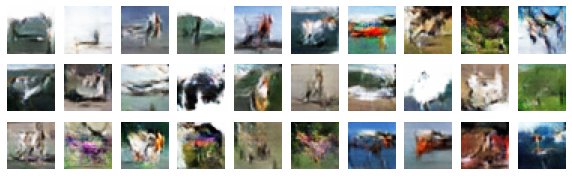

In [ ]:
train_gan(gan, dataset, noise_input, 40)

# Adaptables Generator & Discriminator. 

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def adapt_generator(initial_0, initial_1, nodes, upsamplings, multnodes = 1.0, endnodes = 3, input_noise=100):
  #initial_0, initial_1: size of the initial mini image. 
  #nodes: nodes in the first Dense layers. 
  #upsamplings: number og upsamplings bucles. 
  #multnodes: a multiplicator to modify the nodes in each upsampling bucle. 
  #endnodes: nodes of the last layer. 
  #input_noise: size of the noise. 

  model = keras.models.Sequential()

  #First Dense layer. 
  model.add(keras.layers.Dense(initial_0 * initial_1 * nodes, input_dim=input_noise, 
                               activation=keras.layers.LeakyReLU(alpha=0.2)))
  model.add(keras.layers.Reshape([initial_0, initial_1, nodes]))
  model.add(keras.layers.BatchNormalization())

  #Upsampling bucles. 
  nodeslayers = nodes
  for i in range(upsamplings-1):
    nodeslayers = nodeslayers * multnodes
    model.add(keras.layers.Conv2DTranspose(nodeslayers , kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)))
    model.add(keras.layers.BatchNormalization())

  #last upsample and last layer. 
  model.add(keras.layers.Conv2DTranspose(endnodes, kernel_size=4, strides=2, padding="SAME", 
                                 activation='tanh'))
  
  return model



In [ ]:
def adapt_discriminator(nodes, downsamples, multnodes = 1.0, in_shape=[32, 32, 3]):
  #nodes: nodes in the first Dense layers.
  #downsamples: number of downsamples bucles. 
  #multnodes: a multiplicator to modify the nodes in each downsample bucle.
  #in_shape: Shape of the input image. 

  model = keras.models.Sequential()
  
  #input layer % first downsample 
  model.add(keras.layers.Conv2D(nodes, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=in_shape))
  model.add(keras.layers.Dropout(0.4))
  
  #creating downsamples
  nodeslayers = nodes
  for i in range(downsamples - 1):
    nodeslayers = nodeslayers * multnodes
    model.add(keras.layers.Conv2D(nodeslayers, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)))
    model.add(keras.layers.Dropout(0.4))
  
  #ending model
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  
  return model
  

In [ ]:
adapt_gene = adapt_generator(4, 4, 128, 3, multnodes = 0.5)
adapt_disc = adapt_discriminator(64, 3, multnodes = 2)

In [ ]:
adapt_gene.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              206848    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 64)         131136    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 64)         256       
 hNormalization)                                                 
                                                        

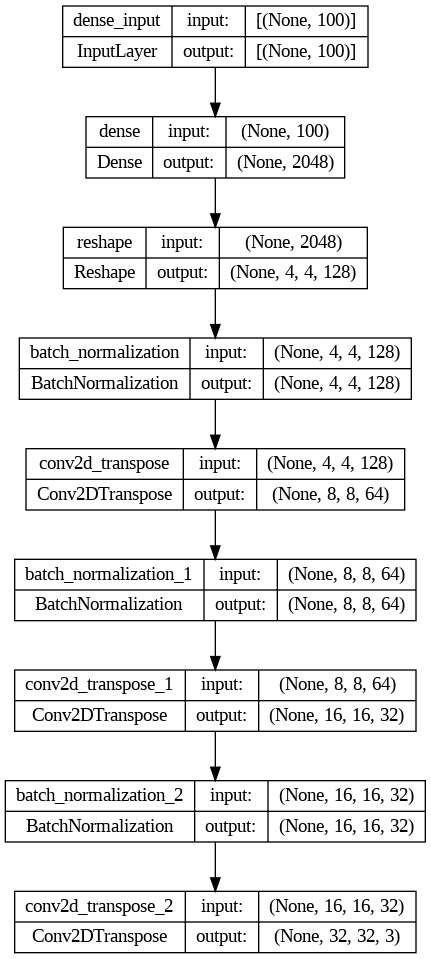

In [ ]:
plot_model(adapt_gene, show_shapes=True, 
           show_layer_names=True)

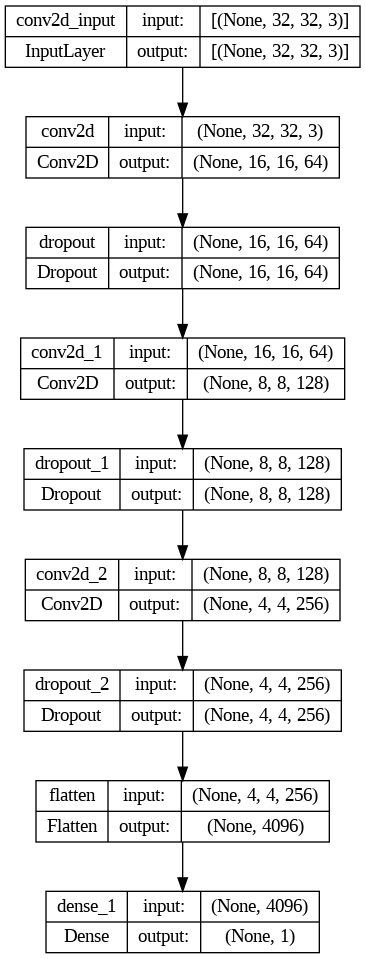

In [ ]:
plot_model(adapt_disc, show_shapes=True, 
           show_layer_names=True)

In [ ]:
adapt_gana2 = keras.models.Sequential([adapt_gene, adapt_disc])

In [ ]:
optimizer_desc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gen = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
adapt_disc.compile(loss='binary_crossentropy', optimizer=optimizer_desc, metrics=['accuracy'])

adapt_disc.trainable = False
adapt_gana2.compile(loss="binary_crossentropy", optimizer=optimizer_gen)

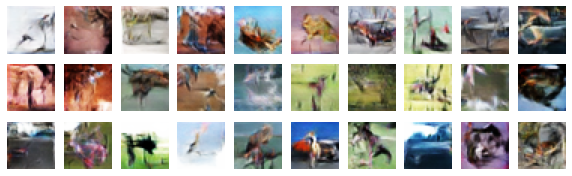

In [ ]:
train_gan(adapt_gana2, dataset, noise_input, 100)